In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

data_names = npzfile.files
n_files = len(npzfile.files)

new_datas = [0]*n_files
for i in range(n_files):
    new_datas[i] = npzfile[data_names[i]]

print(data_names)
print(new_datas)
print(new_datas[0].shape)
print(new_datas[3].shape)

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
[array([1979, 1979, 1979, ..., 2022, 2022, 2022]), array([ 1,  1,  1, ..., 11, 11, 11]), array([ 1,  2,  3, ..., 14, 15, 16]), array([ 0.142507  , -0.2042    , -0.15861   , ...,  0.63895518,
        0.71995491,  0.67032343]), array([ 1.05047   ,  1.37361   ,  1.53943   , ..., -0.39565107,
       -0.2206952 , -0.1839911 ]), array([6., 7., 7., ..., 4., 4., 4.]), array([1.0600899 , 1.3887    , 1.54758   , ..., 0.7515341 , 0.75302154,
       0.69511598])]
(16026,)
(16026,)


In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

N = len(new_datas[0]) # the total number of days in new dataset
n = 10000 # the number of days for training
c = 365 # the number of dropped buffer set
m = N-n-c # the number of days for testing


n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]

palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

In [4]:
print(m)

5661


In [5]:
max_lead_time = m + 1 - max(widths)
lead_time = 60
n_pred = 365*2 # 14*365
# width + lead_time + n_pred-1 <= m

### Independent RMMs

In [6]:
# Independent
dics_total = {}
cor_total = {}
rmse_total = {}
phase_err_total = {}
amplitude_err_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for data_name in ['RMM1','RMM2']:
            mjo_model.train_mjo(data_name)
            mjo_model.pred_mjo(data_name, lead_time, n_pred)

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total[n1] = cor_width
    rmse_total[n1] = rmse_width
    phase_err_total[n1] = phase_err_width
    amplitude_err_total[n1] = amplitude_err_width

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


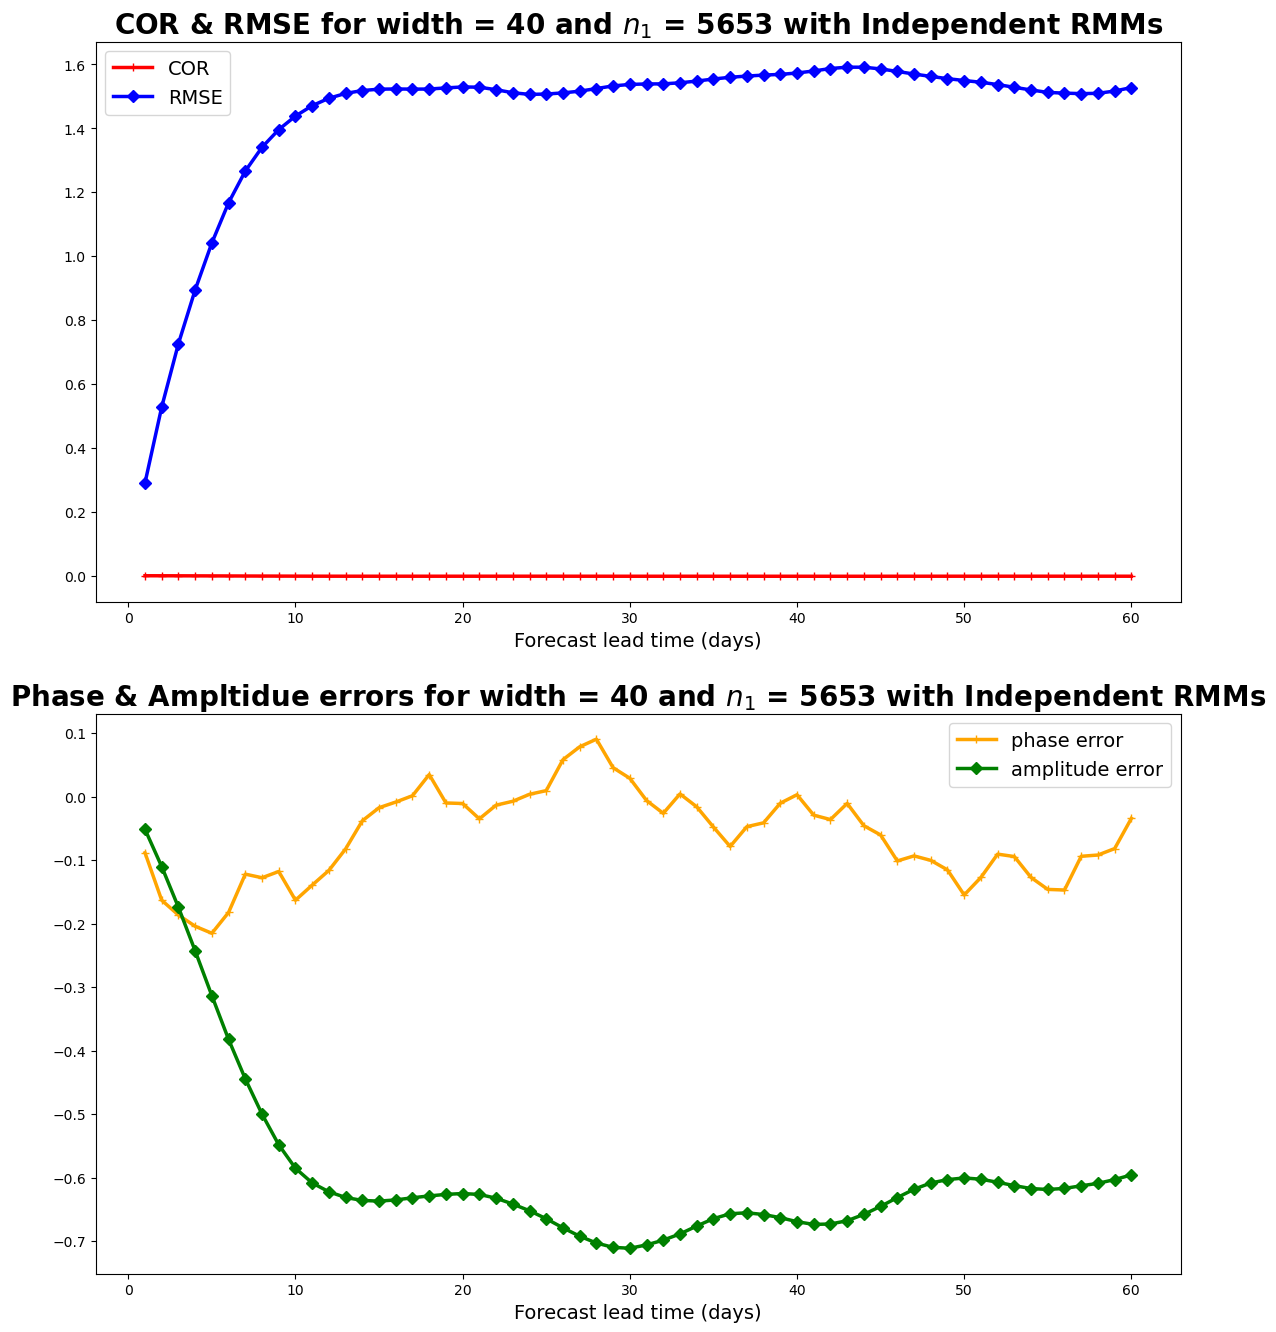

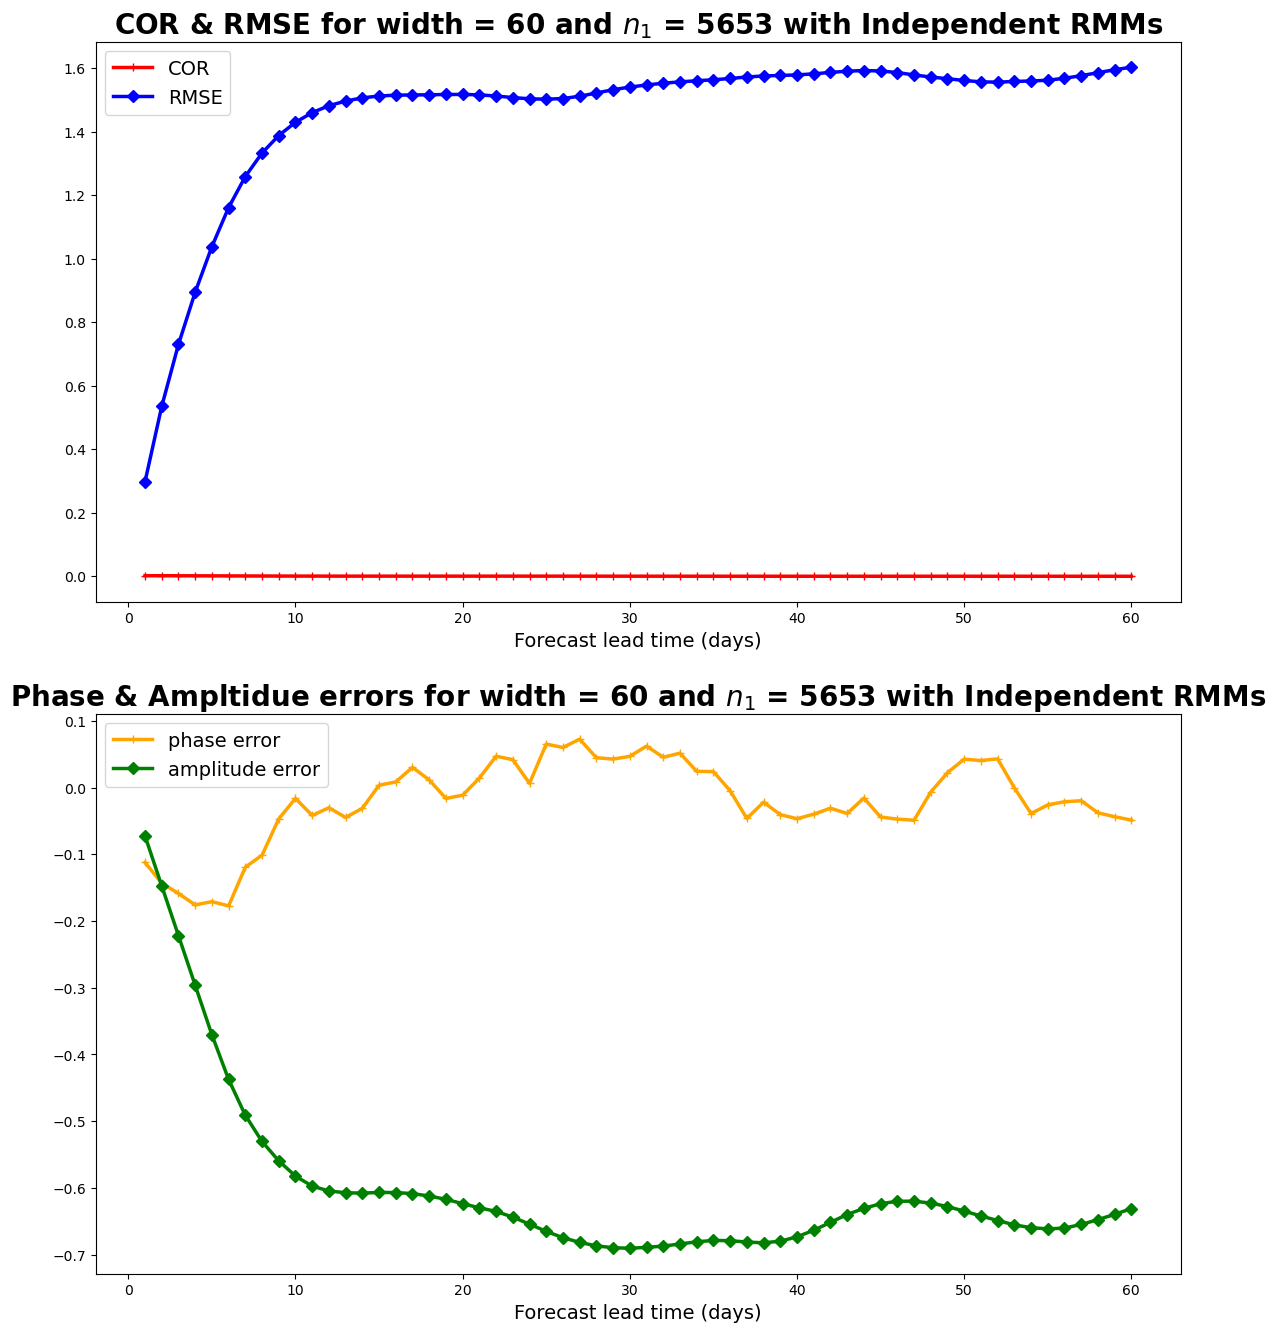

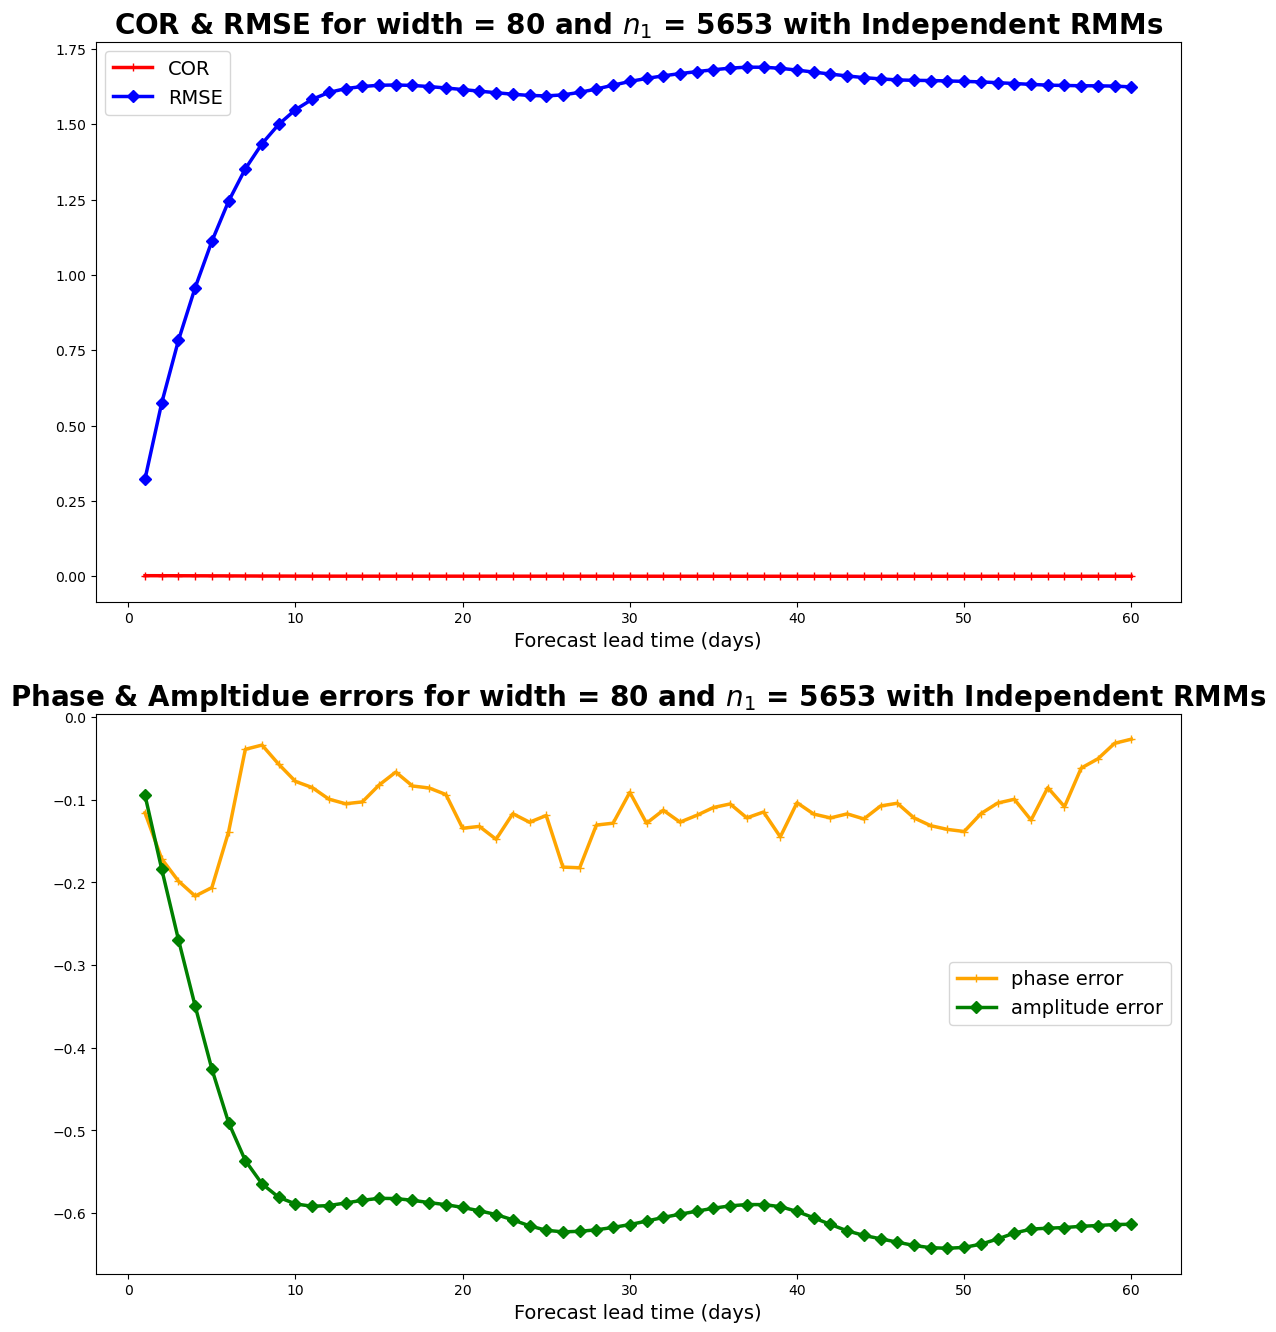

In [10]:
# Plot
for n1 in n1s:
    for width in widths:
        _cor = cor_total[n1][width]
        _rmse = rmse_total[n1][width]
        _phase_err = phase_err_total[n1][width]
        _amplitude_err = amplitude_err_total[n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 16))
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        axs[0].plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].legend(['COR', 'RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with Independent RMMs', fontsize=20, fontweight="bold")

        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        axs[1].plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].legend(['phase error', 'amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs

In [11]:
# Dependent
dics_total = {}
cor_total = {}
rmse_total = {}
phase_err_total = {}
amplitude_err_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics

    cor_width = {}
    rmse_width = {}
    phase_err_width = {}
    amplitude_err_width = {}
    for width in widths:
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        mjo_model.train_mjo(Depend=True)
        for data_name in ['RMM1','RMM2']:
            mjo_model.pred_mjo(data_name, lead_time, n_pred)

        # compute errors
        mjo_model.obs_extract()
        cor_width[width] = mjo_model.cor()
        rmse_width[width] = mjo_model.rmse()
        phase_err_width[width] = mjo_model.phase_err()
        amplitude_err_width[width] = mjo_model.amplitude_err()
        
    cor_total[n1] = cor_width
    rmse_total[n1] = rmse_width
    phase_err_total[n1] = phase_err_width
    amplitude_err_total[n1] = amplitude_err_width

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


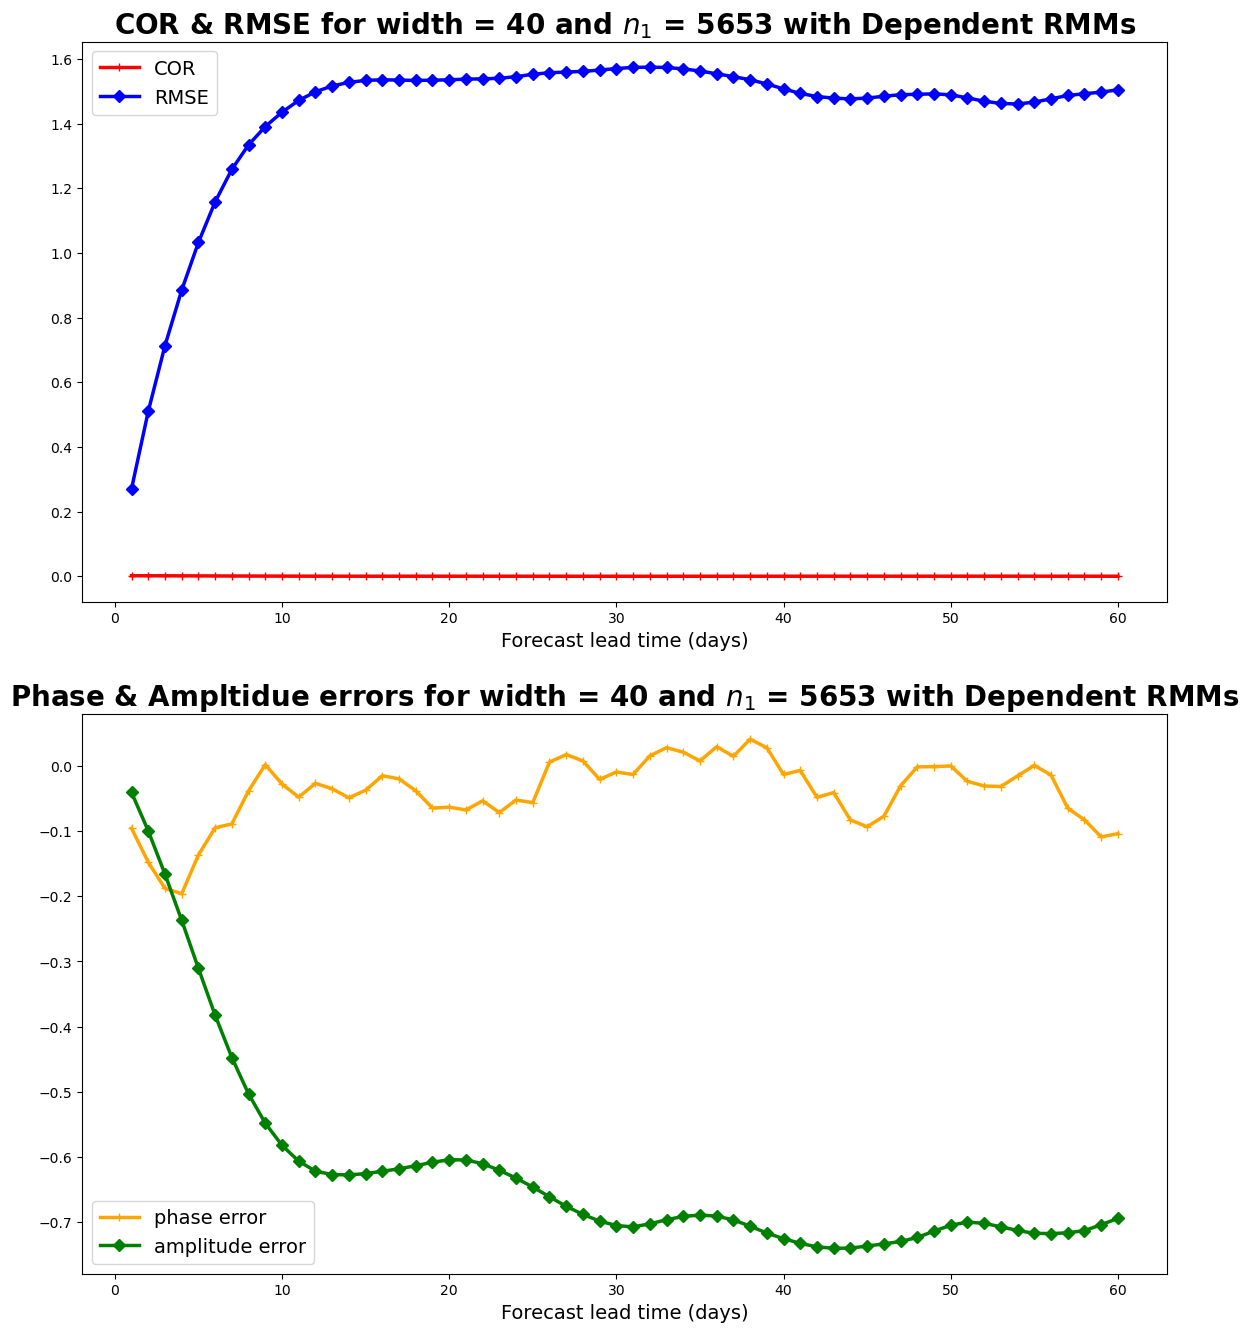

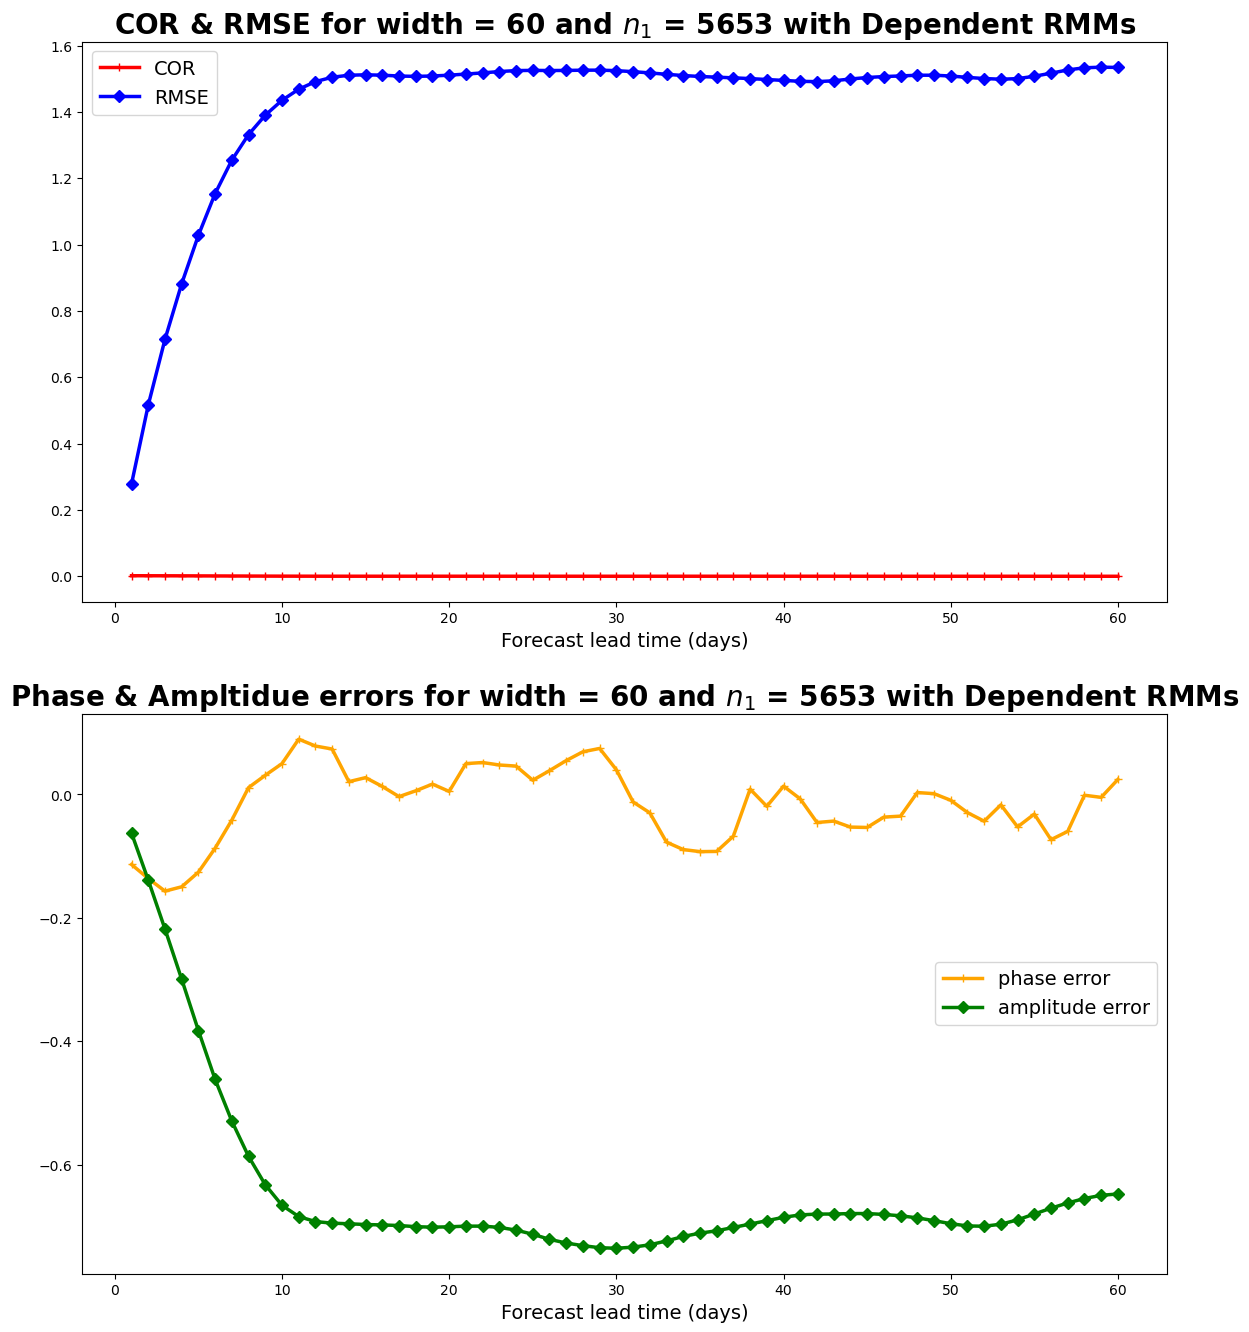

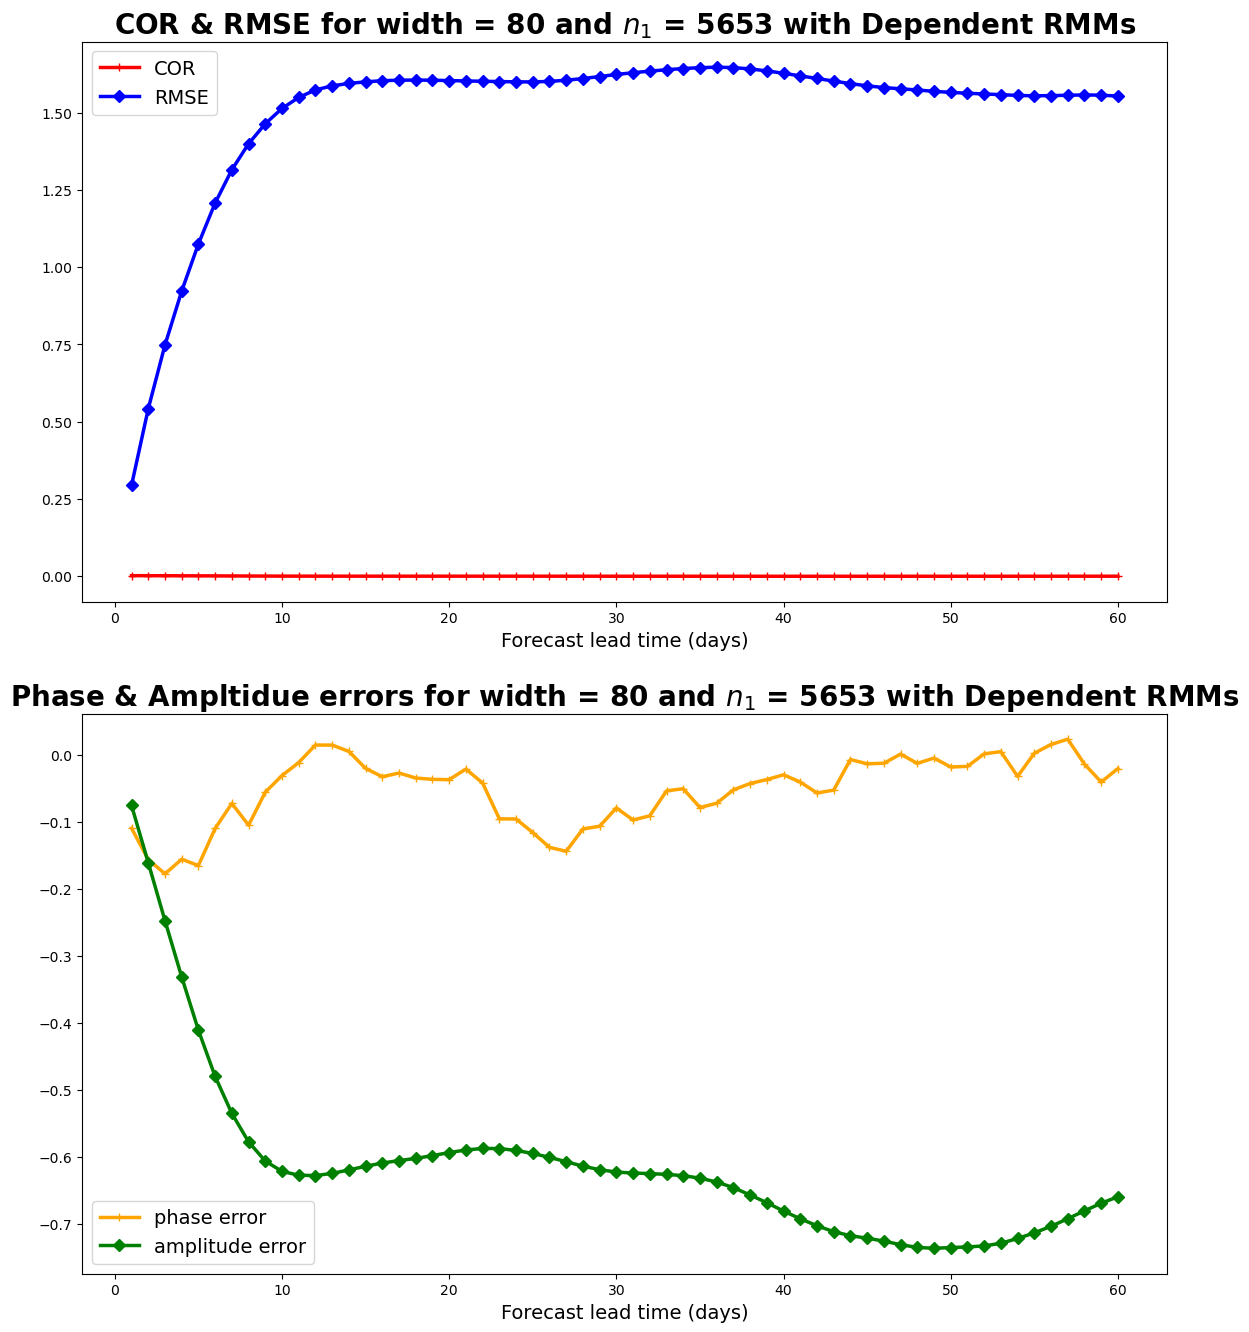

In [12]:
# Plot
for n1 in n1s:
    for width in widths:
        _cor = cor_total[n1][width]
        _rmse = rmse_total[n1][width]
        _phase_err = phase_err_total[n1][width]
        _amplitude_err = amplitude_err_total[n1][width]
        
        fig, axs = plt.subplots(2, 1, figsize=(14, 16))
        axs[0].plot(np.arange(1,lead_time+1), _cor, color='red', linewidth=2.5, marker='+')
        axs[0].plot(np.arange(1,lead_time+1), _rmse, color='blue', linewidth=2.5, marker='D')

        axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[0].legend(['COR', 'RMSE'], fontsize=14)
        axs[0].set_title(f'COR & RMSE for width = {width} and $n_1$ = {n1} with Dependent RMMs', fontsize=20, fontweight="bold")

        axs[1].plot(np.arange(1,lead_time+1), _phase_err, color='orange', linewidth=2.5, marker='+')
        axs[1].plot(np.arange(1,lead_time+1), _amplitude_err, color='green', linewidth=2.5, marker='D')

        axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
        axs[1].legend(['phase error', 'amplitude error'], fontsize=14)
        axs[1].set_title(f'Phase & Ampltidue errors for width = {width} and $n_1$ = {n1} with Dependent RMMs', fontsize=20, fontweight="bold")